In [1]:
import pandas as pd
import dask.dataframe as dd



## очистили номера телефонов в данных о кампаниях и пользователя, и выполнили join


In [2]:
events = dd.read_csv("/Users/19823674/Downloads/event_data.csv", dtype={'user_phone': 'object', 'event_type': 'object', 'event_dtm': 'object', 'event_status': 'object', 'update_dtm': 'object', 'payout': 'float64', 'currency': 'object', 'product_type': 'object'})
adv = dd.read_csv("/Users/19823674/Downloads/adv_data.csv", dtype={'user_id': 'object', 'campaign_type': 'object', 'campaign_start_dtm': 'object', 'campaign_end_dtm': 'object', 'source_medium': 'object', 'utm_campaign': 'object', 'interface': 'object', 'currency': 'object', 'campaign_cost': 'float64'})
users = dd.read_csv("/Users/19823674/Downloads/users_data.csv", dtype={'user_phone': 'object', 'user_id': 'object', 'registration_dtm': 'object', 'delete_dtm': 'object'})


In [11]:
users.head()

,user_phone,user_id,registration_dtm,delete_dtm
0,79100004508,0000038524a303ed5876b823574848e0,2023-01-15 15:33:14.952938,NaN
1,79100005383,000003ef5bdfb2545c8d5ab693142e30,2022-11-21 22:43:54.418792,NaN
2,79100006444,0000056caffa28b60bf17bc69fe4366f,2022-12-23 03:00:04.088219,NaN
3,79100007221,00000a6f236f49c556e9a7b31d1b01e4,2022-12-23 03:31:50.935786,NaN
4,79100009619,00000cbd32277c99f2bd5e180a21f2b2,2023-01-25 14:31:17.234998,NaN


In [10]:
adv.head()

,user_id,campaign_type,campaign_start_dtm,campaign_end_dtm,source_medium,utm_campaign,interface,currency,campaign_cost
0,db00f9c699edacc50090172cfaa3b43a,show,2023-09-18 19:39:25.390618,2023-09-18 19:39:25.390618,finance.rambler.ru / cpm,rebrand_megamaket_reels,app,RUB,NaN
1,88aa22bca4fa1d6da73deb4b5c5ee8c0,show,2023-04-11 06:47:33.199369,2023-04-11 06:47:33.199369,yandex / organic,adv_retarget_brandkeys,web,RUB,NaN
2,e9e12347e50732804d2f8ded00743a07,show,2023-10-28 04:35:48.329870,2023-10-28 04:35:48.329870,yandex / organic,bk_light_brandkeys,web,RUB,NaN
3,fa0cd363d1978a27a078152cd263c670,show,2023-05-28 18:25:18.694051,2023-05-28 18:25:18.694051,yandex / organic,retarget_mind_response,api,RUB,NaN
4,fa0cd363d1978a27a078152cd263c670,click,2023-05-31 18:55:55.352680,2023-05-31 18:55:55.352680,regular / sms,light_clickarrow_clickarrow,api,USD,1.34


In [7]:
events.head()

,id,user_phone,event_type,event_dtm,event_status,update_dtm,payout,currency,product_type
0,1263769bddda6eaaf7c8b8b22812ad6a063ad234d80782...,+79140092454,show,2023-10-05 12:03:04.125806,NaN,NaN,NaN,RUB,mortgage
1,ae05865023d28ae72dd17955851263ead2d4daf11c69e0...,+79125904946,show,2023-05-16 10:16:54.554523,NaN,NaN,NaN,RUB,loan
2,9861b00e9c9a99a6fdb2e5c11beebe9581eb1dda36ddc4...,+79184556300,show,2023-12-23 22:46:44.066599,NaN,NaN,NaN,RUB,loan
3,349366af4823add107077299482f21031941fc6d4cd571...,+79119287528,show,2023-07-30 05:25:46.285514,NaN,NaN,NaN,RUB,loan
4,2be2933460f58bb2d9a311ede6bb6ee064989568ab57b8...,+79119287528,click,2023-07-30 05:25:46.285514,NaN,2023-07-30 05:42:59.014970,2.18,USD,loan


In [3]:
users['user_phone'] = users['user_phone'].str.replace('+', '')
users['user_phone'] = users['user_phone'].str.replace('(', '')
users['user_phone'] = users['user_phone'].str.replace(')', '')
users['user_phone'] = users['user_phone'].str.replace(' ', '')
users['user_phone'] = users['user_phone'].str.replace('-', '')


events['user_phone'] = events['user_phone'].str.replace('+', '')
events['user_phone'] = events['user_phone'].str.replace('(', '')
events['user_phone'] = events['user_phone'].str.replace(')', '')
events['user_phone'] = events['user_phone'].str.replace(' ', '')
events['user_phone'] = events['user_phone'].str.replace('-', '')

In [4]:
joined = dd.merge(events, users[['user_phone', 'user_id']], on='user_phone', how='inner')
final_data = dd.merge(joined, adv, on='user_id', how='inner')


In [5]:
cmpn_events = final_data[["user_id", "event_type", "event_dtm", "event_status", "product_type", "source_medium", "utm_campaign", "interface", "campaign_start_dtm", "campaign_end_dtm", "campaign_type", "payout", "campaign_cost"]]
cmpn_events.to_parquet("/Users/19823674/Downloads/result4.pqt")

In [6]:
ATRIBUTION_WINDOW = 30
CMPN_WINDOW = 21


## Далее выделяем целевые события, которые привели к конверсии

In [130]:
cmpn_events = pd.read_parquet("/Users/19823674/Downloads/result4.pqt")
sales = cmpn_events[(cmpn_events["event_status"] == "sale")]


In [131]:
sales = sales[["user_id", "product_type", "interface", "event_dtm"]]
sales = sales.rename({"event_dtm": "sale_dtm"}, axis="columns")
sales['sale_dtm'] = pd.to_datetime(sales['sale_dtm'], format='%Y-%m-%d %H:%M:%S.%f')




## сделали фильтрацию, чтобы время целевого события было в окне действия кампании. За окно кампании брали дату начала + 21 день

In [87]:
cmpn_events['campaign_start_dtm'] = pd.to_datetime(cmpn_events['campaign_start_dtm'], format='%Y-%m-%d %H:%M:%S.%f')
cmpn_events['campaign_end_dtm'] = pd.to_datetime(cmpn_events['campaign_end_dtm'], format='%Y-%m-%d %H:%M:%S.%f')
cmpn_events['event_dtm'] = pd.to_datetime(cmpn_events['event_dtm'], format='%Y-%m-%d %H:%M:%S.%f')

cmpn_events = cmpn_events[(cmpn_events["event_dtm"] >= cmpn_events["campaign_start_dtm"]) & (cmpn_events["event_dtm"] <= (cmpn_events["campaign_end_dtm"] + pd.DateOffset(60)))]

In [88]:
cmpn_events


,user_id,event_type,event_dtm,event_status,product_type,source_medium,utm_campaign,interface,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
__null_dask_index__,,,,,,,,,,,,,
27,258538796e7fab2add345c73832f98d9,show,2023-10-08 06:15:21.242436,None,loan,google / organic,title_brandkeys_title,app,2023-09-10 12:50:29.795532,2023-09-10 12:50:29.795532,show,NaN,NaN
28,258538796e7fab2add345c73832f98d9,show,2023-10-08 06:15:21.242436,None,loan,yandex / organic,client_clickarrow_reels,web,2023-09-16 18:07:02.313501,2023-09-16 18:07:02.313501,click,NaN,0.0
53,60350059ea9353386e00375be1080f09,show,2024-01-16 02:13:01.640361,None,loan,yandex / organic,operator_clickarrow_rebrand,web,2023-11-28 22:51:32.842787,2023-11-28 22:51:32.842787,show,NaN,NaN
55,06dfd5182dbf472f69e336b714d444bf,show,2023-05-30 06:24:17.152190,None,loan,yandex / organic,operator_target_title,app,2023-04-20 18:12:32.535950,2023-04-20 18:12:32.535950,show,NaN,NaN
58,e2627842ab81240d28880df7563014c8,show,2023-05-24 12:12:21.018539,None,loan,ru.android.bankproduct_rustore / mobile_app,case_response_brandkeys,app,2023-03-26 21:34:53.120079,2023-03-26 21:34:53.120079,show,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324764,652d38f4294d35210e16565c7ddc36b9,click,2023-05-05 16:31:56.480004,None,loan,yandex / organic,rebrand_reels_client,app,2023-03-17 18:39:20.198924,2023-03-17 18:39:20.198924,show,0.0,NaN
324765,652d38f4294d35210e16565c7ddc36b9,conversion,2023-05-05 16:31:56.480004,deal,loan,yandex / organic,rebrand_reels_client,app,2023-03-17 18:39:20.198924,2023-03-17 18:39:20.198924,show,0.0,NaN
324766,652d38f4294d35210e16565c7ddc36b9,conversion,2023-05-05 16:31:56.480004,approve,loan,yandex / organic,rebrand_reels_client,app,2023-03-17 18:39:20.198924,2023-03-17 18:39:20.198924,show,0.0,NaN


## Выполняем фильтрацию для событий - тип события = типу события в кампании

In [90]:
cmpn_events = cmpn_events[cmpn_events["event_type"] == cmpn_events["campaign_type"]]


In [91]:
cmpn_events

,user_id,event_type,event_dtm,event_status,product_type,source_medium,utm_campaign,interface,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
__null_dask_index__,,,,,,,,,,,,,
27,258538796e7fab2add345c73832f98d9,show,2023-10-08 06:15:21.242436,None,loan,google / organic,title_brandkeys_title,app,2023-09-10 12:50:29.795532,2023-09-10 12:50:29.795532,show,NaN,NaN
53,60350059ea9353386e00375be1080f09,show,2024-01-16 02:13:01.640361,None,loan,yandex / organic,operator_clickarrow_rebrand,web,2023-11-28 22:51:32.842787,2023-11-28 22:51:32.842787,show,NaN,NaN
55,06dfd5182dbf472f69e336b714d444bf,show,2023-05-30 06:24:17.152190,None,loan,yandex / organic,operator_target_title,app,2023-04-20 18:12:32.535950,2023-04-20 18:12:32.535950,show,NaN,NaN
58,e2627842ab81240d28880df7563014c8,show,2023-05-24 12:12:21.018539,None,loan,ru.android.bankproduct_rustore / mobile_app,case_response_brandkeys,app,2023-03-26 21:34:53.120079,2023-03-26 21:34:53.120079,show,NaN,NaN
64,a959d53933eb1c569a0a0b6dd0210e92,show,2023-12-12 03:14:52.600288,None,mortgage,yandex / organic,bk_reels_case,web,2023-12-01 21:14:30.114329,2023-12-01 21:14:30.114329,show,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324706,d8b5233390562257c5157a828412df8e,show,2023-09-08 19:43:54.865835,None,loan,ios / mobile_app,clickarrow_title_bk,app,2023-08-19 10:26:50.497111,2023-08-19 10:26:50.497111,show,NaN,NaN
324739,7010b9fabc2a3668cba0d3c33d8663b4,show,2023-10-13 01:09:22.582015,None,loan,yandex / organic,case_title_reels,web,2023-10-02 10:58:19.001805,2023-10-02 10:58:19.001805,show,NaN,NaN
324742,7010b9fabc2a3668cba0d3c33d8663b4,click,2023-10-13 01:09:22.582015,None,loan,ios / mobile_app,market_reels_reels,app,2023-09-29 18:14:54.988627,2023-09-29 18:14:54.988627,click,0.0,0.0


## джоиним события, которые привели к конверсии на все события, учитываем окно атрибуции

In [104]:
atr

,user_id,product_type,interface_x,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,interface_y,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
0,b11e520f0ed934bce04d74b30e14e101,loan,web,2023-10-06 23:07:05.209282,show,2023-10-06 23:07:05.209282,None,google / organic,megamaket_retarget_light,web,2023-08-24 07:34:48.605284,2023-08-24 07:34:48.605284,show,NaN,NaN
1,e3308297de6dd1687f951dce2b96e607,mortgage,app,2023-05-13 18:31:52.196659,show,2023-05-13 18:31:52.196659,None,yandex / organic,brandkeys_response_target,app,2023-04-01 02:58:16.091236,2023-04-01 02:58:16.091236,show,NaN,NaN
2,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,app,2023-03-24 04:51:42.019789,show,2023-03-24 04:51:42.019789,None,ya.ru / cpc,rebrand_case_operator,app,2023-02-04 19:20:13.708744,2023-02-04 19:20:13.708744,show,NaN,NaN
3,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,app,2023-03-24 04:51:42.019789,click,2023-03-24 04:51:42.019789,None,zen.yandex.ru / cpm,title_megamaket_mind,web,2023-02-03 22:19:32.767655,2023-02-03 22:19:32.767655,click,0.0,0.0
4,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,web,2023-03-24 04:51:42.019789,show,2023-03-24 04:51:42.019789,None,ya.ru / cpc,rebrand_case_operator,app,2023-02-04 19:20:13.708744,2023-02-04 19:20:13.708744,show,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28831,5a3fac97387245caa86daedba2440268,loan,app,2023-10-01 07:06:20.549918,show,2023-10-01 07:06:20.549918,None,ios / mobile_app,market_brandkeys_megamaket,app,2023-09-23 09:11:14.583836,2023-09-23 09:11:14.583836,show,NaN,NaN
28832,46869475aa35a302ee2ca043c4db0b89,mortgage,api,2023-08-21 13:03:19.194317,show,2023-08-21 13:03:19.194317,None,ya.ru / cpc,light_megamaket_brandkeys,api,2023-07-26 17:27:42.688311,2023-07-26 17:27:42.688311,show,NaN,NaN
28833,ccc0a9795fb2edcc2bda7296066f86bc,loan,web,2023-09-03 17:33:56.800868,show,2023-09-03 17:33:56.800868,None,yandex / organic,bk_megamaket_target,web,2023-08-29 19:24:42.031284,2023-08-29 19:24:42.031284,show,NaN,NaN
28834,6cf864a98018c25cdbe21175926a6f5e,loan,web,2023-12-13 10:36:37.066488,show,2023-12-13 10:36:37.066488,None,not-set / none,None,web,2023-11-11 07:29:43.026765,2023-11-11 07:29:43.026765,show,NaN,NaN


In [105]:
atr = pd.merge(sales, cmpn_events, on=["user_id", "product_type"], how='inner')
atr = atr[(atr["event_dtm"] <= atr["sale_dtm"]) & (atr["event_dtm"] >= (atr["sale_dtm"] - pd.DateOffset(ATRIBUTION_WINDOW)))]

## удаляем статусы событий, которые нас не интересуют в модели атрибуции

In [106]:
atr = atr[~atr.event_status.isin(["deal", "approve"]) ]
atr

,user_id,product_type,interface_x,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,interface_y,campaign_start_dtm,campaign_end_dtm,campaign_type,payout,campaign_cost
0,b11e520f0ed934bce04d74b30e14e101,loan,web,2023-10-06 23:07:05.209282,show,2023-10-06 23:07:05.209282,None,google / organic,megamaket_retarget_light,web,2023-08-24 07:34:48.605284,2023-08-24 07:34:48.605284,show,NaN,NaN
1,e3308297de6dd1687f951dce2b96e607,mortgage,app,2023-05-13 18:31:52.196659,show,2023-05-13 18:31:52.196659,None,yandex / organic,brandkeys_response_target,app,2023-04-01 02:58:16.091236,2023-04-01 02:58:16.091236,show,NaN,NaN
2,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,app,2023-03-24 04:51:42.019789,show,2023-03-24 04:51:42.019789,None,ya.ru / cpc,rebrand_case_operator,app,2023-02-04 19:20:13.708744,2023-02-04 19:20:13.708744,show,NaN,NaN
3,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,app,2023-03-24 04:51:42.019789,click,2023-03-24 04:51:42.019789,None,zen.yandex.ru / cpm,title_megamaket_mind,web,2023-02-03 22:19:32.767655,2023-02-03 22:19:32.767655,click,0.0,0.0
4,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,web,2023-03-24 04:51:42.019789,show,2023-03-24 04:51:42.019789,None,ya.ru / cpc,rebrand_case_operator,app,2023-02-04 19:20:13.708744,2023-02-04 19:20:13.708744,show,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28831,5a3fac97387245caa86daedba2440268,loan,app,2023-10-01 07:06:20.549918,show,2023-10-01 07:06:20.549918,None,ios / mobile_app,market_brandkeys_megamaket,app,2023-09-23 09:11:14.583836,2023-09-23 09:11:14.583836,show,NaN,NaN
28832,46869475aa35a302ee2ca043c4db0b89,mortgage,api,2023-08-21 13:03:19.194317,show,2023-08-21 13:03:19.194317,None,ya.ru / cpc,light_megamaket_brandkeys,api,2023-07-26 17:27:42.688311,2023-07-26 17:27:42.688311,show,NaN,NaN
28833,ccc0a9795fb2edcc2bda7296066f86bc,loan,web,2023-09-03 17:33:56.800868,show,2023-09-03 17:33:56.800868,None,yandex / organic,bk_megamaket_target,web,2023-08-29 19:24:42.031284,2023-08-29 19:24:42.031284,show,NaN,NaN
28834,6cf864a98018c25cdbe21175926a6f5e,loan,web,2023-12-13 10:36:37.066488,show,2023-12-13 10:36:37.066488,None,not-set / none,None,web,2023-11-11 07:29:43.026765,2023-11-11 07:29:43.026765,show,NaN,NaN


In [107]:
atr = atr.drop(["interface_y", "campaign_type"], axis=1)
atr = atr.rename({"interface_x": "interface"}, axis="columns")


In [108]:
atr

,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,payout,campaign_cost
0,b11e520f0ed934bce04d74b30e14e101,loan,web,2023-10-06 23:07:05.209282,show,2023-10-06 23:07:05.209282,None,google / organic,megamaket_retarget_light,2023-08-24 07:34:48.605284,2023-08-24 07:34:48.605284,NaN,NaN
1,e3308297de6dd1687f951dce2b96e607,mortgage,app,2023-05-13 18:31:52.196659,show,2023-05-13 18:31:52.196659,None,yandex / organic,brandkeys_response_target,2023-04-01 02:58:16.091236,2023-04-01 02:58:16.091236,NaN,NaN
2,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,app,2023-03-24 04:51:42.019789,show,2023-03-24 04:51:42.019789,None,ya.ru / cpc,rebrand_case_operator,2023-02-04 19:20:13.708744,2023-02-04 19:20:13.708744,NaN,NaN
3,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,app,2023-03-24 04:51:42.019789,click,2023-03-24 04:51:42.019789,None,zen.yandex.ru / cpm,title_megamaket_mind,2023-02-03 22:19:32.767655,2023-02-03 22:19:32.767655,0.0,0.0
4,e85905f4d08277fd6cb9f2d2f3e9e922,mortgage,web,2023-03-24 04:51:42.019789,show,2023-03-24 04:51:42.019789,None,ya.ru / cpc,rebrand_case_operator,2023-02-04 19:20:13.708744,2023-02-04 19:20:13.708744,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28831,5a3fac97387245caa86daedba2440268,loan,app,2023-10-01 07:06:20.549918,show,2023-10-01 07:06:20.549918,None,ios / mobile_app,market_brandkeys_megamaket,2023-09-23 09:11:14.583836,2023-09-23 09:11:14.583836,NaN,NaN
28832,46869475aa35a302ee2ca043c4db0b89,mortgage,api,2023-08-21 13:03:19.194317,show,2023-08-21 13:03:19.194317,None,ya.ru / cpc,light_megamaket_brandkeys,2023-07-26 17:27:42.688311,2023-07-26 17:27:42.688311,NaN,NaN
28833,ccc0a9795fb2edcc2bda7296066f86bc,loan,web,2023-09-03 17:33:56.800868,show,2023-09-03 17:33:56.800868,None,yandex / organic,bk_megamaket_target,2023-08-29 19:24:42.031284,2023-08-29 19:24:42.031284,NaN,NaN
28834,6cf864a98018c25cdbe21175926a6f5e,loan,web,2023-12-13 10:36:37.066488,show,2023-12-13 10:36:37.066488,None,not-set / none,None,2023-11-11 07:29:43.026765,2023-11-11 07:29:43.026765,NaN,NaN


In [38]:
atr.to_excel("/Users/19823674/Downloads/aggregation2.xlsx")

## построение линейной модели

In [171]:
atr = atr[~atr.event_status.isin(["deal", "approve", "payout"]) ]


In [208]:
import matplotlib.pyplot as plt

def get_model(product):
    linear = ps.sqldf(f"select t.*, count(*) over (partition by user_id) chain_len from atr t where product_type in ('{product}') ")
    linear = ps.sqldf("select t.*, 1.0/chain_len as score, sum(1.0/chain_len) over () total from linear t")
    df = ps.sqldf("select source_medium, sum(score)/total score from linear group by source_medium order by score desc")
    df = df.head(10)

    # Построение гистограммы для топ 10 кампаний

    plt.figure(figsize=(16, 8))

    bar_width = 0.3
    index = range(len(df))

    # Первая система координат для гистограммы

    plt.bar(index, df['score'], bar_width, color='skyblue')

        
    plt.xlabel('Рекламный канал')
    plt.ylabel('Баллы атрибуции')
    plt.title(f"Линейная модель атрибуции для продукта '{product}' (Топ 10 каналов)")
    plt.xticks([i + bar_width for i in index], df.source_medium, rotation=45)
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()


plt.show()

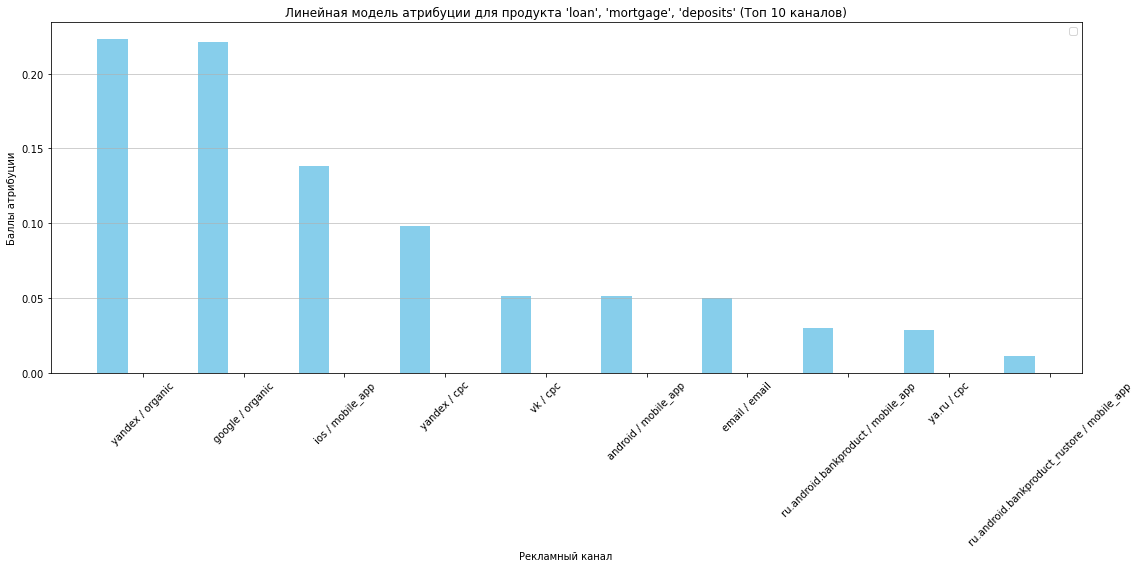

In [209]:
get_model("loan', 'mortgage', 'deposits")


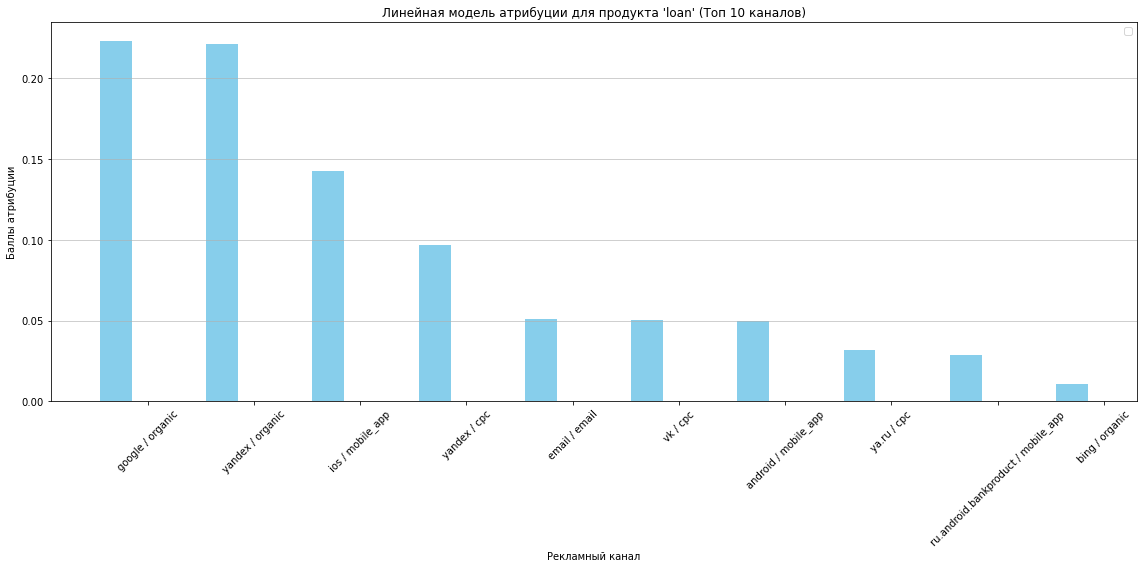

In [210]:
get_model("loan")



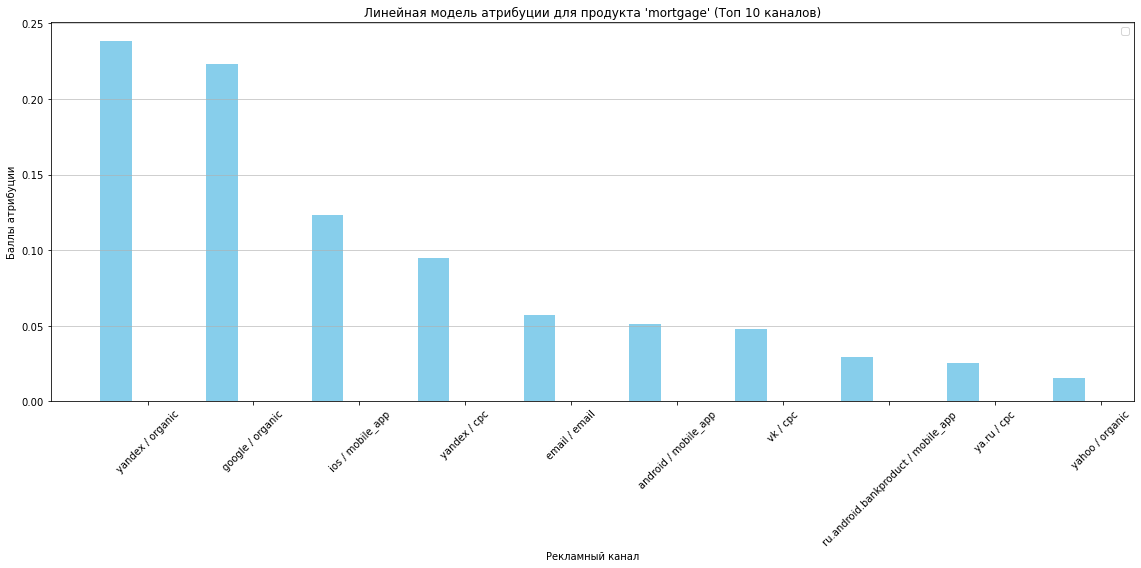

In [211]:
get_model("mortgage")

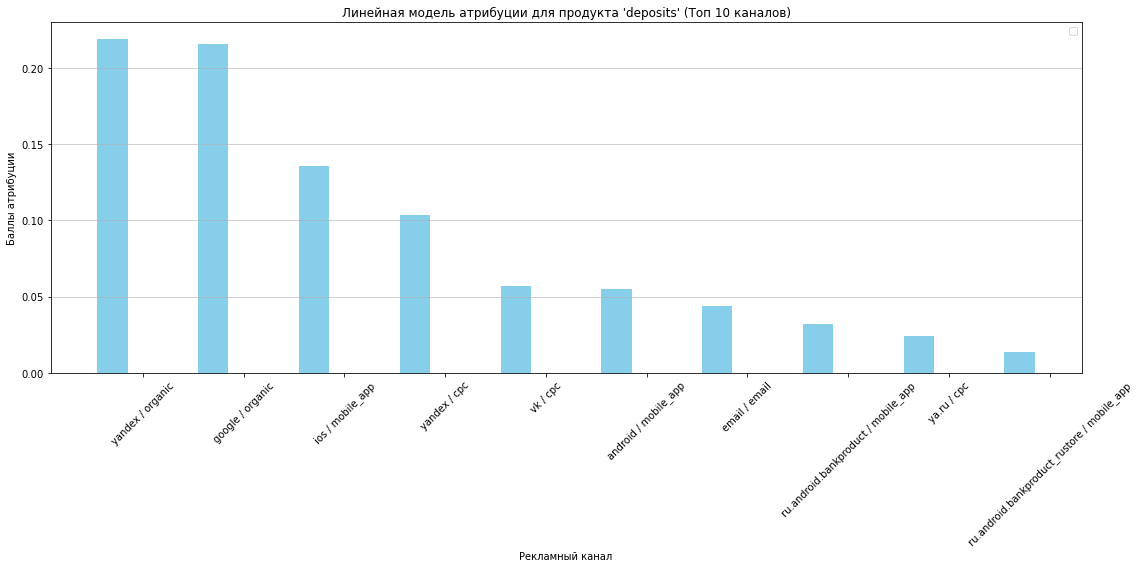

In [212]:
get_model("deposits")

## Допсекция - иссследование цепочек взаимодействия

In [41]:
import pandasql as ps


In [109]:
atr = atr.drop_duplicates() #.drop("interface", axis=1)

In [111]:
aggr = ps.sqldf("""

select row_number() over (partition by user_id, sale_dtm order by sale_dtm) sale_rn, t.*  from atr t

""")

In [213]:
# аномалия в данных. У клиентов  с длиной цепочки >= 2 одинаковый event_dt 
wl = ps.sqldf("select  t.*, count(*) over (partition by user_id) session_len from aggr t")
ps.sqldf("select cnt as 'количество одинаковых envent_dt в цепочке пользователя (длина цепочки > 2)', count(*) from (select  user_id, event_dtm, count(*) as cnt from wl where session_len >= 2 group by user_id, event_dtm order by count(*) desc) group by cnt order by cnt")

,количество одинаковых envent_dt в цепочке пользователя (длина цепочки > 2),count(*)
0,1,29
1,2,1810
2,3,111
3,4,1006
4,6,125
5,8,38
6,9,50
7,10,8
8,12,43
9,15,17


In [123]:
# длина цепочки
chains = ps.sqldf("select  sale_rn, count(*) from aggr  group by sale_rn order by sale_rn")
chains

,sale_rn,count(*)
0,1,11201
1,2,3228
2,3,1411
3,4,1299
4,5,293
5,6,293
6,7,167
7,8,167
8,9,129
9,10,80


In [139]:
ps.sqldf("select  user_id, event_dtm, count(*) as cnt from aggr  group by user_id, event_dtm order by count(*) desc")

,user_id,event_dtm,cnt
0,ed9b80973f96c6985e089f15417663f6,2023-07-20 07:34:37.832514,30
1,22cd759ea6881f14af52b55f6830ceaf,2023-05-29 02:15:21.578525,24
2,b38b0090dad3ca7fea27d0a118f056a0,2023-04-09 21:22:36.136318,24
3,d2eeab26222cf1c4883f4e1157db9185,2024-01-28 03:28:47.289930,24
4,ffcf4f5ff9c8f6dd976d90cccae2f146,2023-03-08 05:32:00.121657,24
...,...,...,...
11216,ffe776797dbbab278e4b43953b3fdb35,2023-07-08 00:03:31.758596,1
11217,fff2257ce87089dcbe9de319e96a32b4,2023-02-15 19:33:56.333394,1
11218,fff3e10be558f391fa3677b118c0c6cb,2023-03-15 17:45:01.889240,1
11219,fff7215ccf0fac2e1318bf690fabd762,2024-01-21 22:09:18.149347,1


,cnt,count(*)
0,1,29
1,2,1810
2,3,111
3,4,1006
4,6,125
5,8,38
6,9,50
7,10,8
8,12,43
9,15,17


In [124]:
ps.sqldf("select  * from aggr where sale_rn = 3")

,sale_rn,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,payout,campaign_cost
0,3,0021fcbe2d31bc92d05b3a2213c24605,loan,app,2023-07-26 08:25:51.309049,conversion,2023-07-26 08:25:51.309049,sale,google / organic,title_brandkeys_operator,2023-06-06 04:20:45.258379,2023-06-06 04:20:45.258379,NaN,0.0
1,3,0083d00f7037fb9b726fbf06d2fbc663,loan,app,2023-03-08 06:04:27.292913,show,2023-03-08 06:04:27.292913,None,yandex / organic,mind_reels_mind,2023-02-13 13:50:50.563024,2023-02-13 13:50:50.563024,NaN,NaN
2,3,00aaede97c275b84de354b7703ec48d3,loan,api,2023-11-28 09:55:29.918783,show,2023-11-28 09:55:29.918783,None,pikabu.ru / cpm,market_title_title,2023-10-16 06:38:59.320219,2023-10-16 06:38:59.320219,NaN,NaN
3,3,00c027a87ea76a4a27d0b6fc99e39a66,deposits,app,2023-04-06 00:34:02.082165,click,2023-04-06 00:34:02.082165,None,android / mobile_app,megamaket_client_client,2023-02-08 05:07:56.539922,2023-02-08 05:07:56.539922,267.0,0.0
4,3,00ff98c1f7cf229580713dbffec3afdb,loan,web,2023-02-11 18:58:34.769544,conversion,2023-02-11 18:58:34.769544,sale,yandex / organic,title_brandkeys_adv,2023-01-26 15:28:51.700513,2023-01-26 15:28:51.700513,4743.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,3,ff384186aacb3a581a8724a0628bd6df,mortgage,web,2023-10-27 19:44:30.493465,show,2023-10-27 19:44:30.493465,None,bing / organic,target_reels_response,2023-10-08 16:06:10.523415,2023-10-08 16:06:10.523415,NaN,NaN
1407,3,ff634215be439d02021b59b791229c79,loan,api,2023-11-10 10:14:44.030080,show,2023-11-10 10:14:44.030080,None,yandex / cpc,megamaket_title_bk,2023-10-13 01:42:10.597935,2023-10-13 01:42:10.597935,NaN,NaN
1408,3,ffcf4f5ff9c8f6dd976d90cccae2f146,loan,web,2023-03-08 05:32:00.121657,conversion,2023-03-08 05:32:00.121657,sale,ru.android.bankproduct / mobile_app,retarget_case_adv,2023-02-03 01:49:04.914421,2023-02-03 01:49:04.914421,4987.0,0.0
1409,3,ffd7822410f3c69616bb0155c268762e,loan,api,2023-08-13 23:08:02.366966,conversion,2023-08-13 23:08:02.366966,sale,yandex / cpc,mind_title_target,2023-07-16 00:43:29.345994,2023-07-16 00:43:29.345994,NaN,0.0


In [128]:
ps.sqldf("""

select user_id, event_status, count(*)  from atr t where event_status = 'sale' group by user_id, event_status

""")


,user_id,event_status,count(*)
0,0021fcbe2d31bc92d05b3a2213c24605,sale,6
1,00c027a87ea76a4a27d0b6fc99e39a66,sale,9
2,00ff98c1f7cf229580713dbffec3afdb,sale,4
3,0290b9548495f67bccc1a8825b6b5171,sale,4
4,03567202e5210744094dd58245da41b1,sale,1
...,...,...,...
350,fbc6313e2b8c2f6fab8fcd8cba0343a9,sale,2
351,fbea047078b2d5133c84e0feb9da89e3,sale,2
352,fe626c00520e47b76dd3f792031199bf,sale,2
353,ffcf4f5ff9c8f6dd976d90cccae2f146,sale,9


In [140]:
ps.sqldf("select * from atr where user_id = 'd2eeab26222cf1c4883f4e1157db9185'")

,user_id,product_type,interface,sale_dtm,event_type,event_dtm,event_status,source_medium,utm_campaign,campaign_start_dtm,campaign_end_dtm,payout,campaign_cost
0,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,show,2024-01-28 03:28:47.289930,None,yandex / organic,operator_brandkeys_brandkeys,2023-12-28 11:39:29.832496,2023-12-28 11:39:29.832496,NaN,NaN
1,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,click,2024-01-28 03:28:47.289930,None,google / organic,adv_brandkeys_megamaket,2024-01-18 09:30:21.183792,2024-01-18 09:30:21.183792,0.0,0.00
2,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,conversion,2024-01-28 03:28:47.289930,sale,google / organic,megamaket_rebrand_adv,2024-01-14 18:34:57.194649,2024-01-14 18:34:57.194649,NaN,0.00
3,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,conversion,2024-01-28 03:28:47.289930,sale,google / organic,target_bk_rebrand,2023-12-16 16:04:02.690388,2023-12-16 16:04:02.690388,NaN,0.00
4,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,conversion,2024-01-28 03:28:47.289930,sale,ios / mobile_app,retarget_market_reels,2024-01-05 05:56:38.969419,2024-01-05 05:56:38.969419,NaN,4045.19
5,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,conversion,2024-01-28 03:28:47.289930,payout,google / organic,megamaket_rebrand_adv,2024-01-14 18:34:57.194649,2024-01-14 18:34:57.194649,NaN,0.00
6,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,conversion,2024-01-28 03:28:47.289930,payout,google / organic,target_bk_rebrand,2023-12-16 16:04:02.690388,2023-12-16 16:04:02.690388,NaN,0.00
7,d2eeab26222cf1c4883f4e1157db9185,loan,app,2024-01-28 03:28:47.289930,conversion,2024-01-28 03:28:47.289930,payout,ios / mobile_app,retarget_market_reels,2024-01-05 05:56:38.969419,2024-01-05 05:56:38.969419,NaN,4045.19
8,d2eeab26222cf1c4883f4e1157db9185,loan,web,2024-01-28 03:28:47.289930,show,2024-01-28 03:28:47.289930,None,yandex / organic,operator_brandkeys_brandkeys,2023-12-28 11:39:29.832496,2023-12-28 11:39:29.832496,NaN,NaN
9,d2eeab26222cf1c4883f4e1157db9185,loan,web,2024-01-28 03:28:47.289930,click,2024-01-28 03:28:47.289930,None,google / organic,adv_brandkeys_megamaket,2024-01-18 09:30:21.183792,2024-01-18 09:30:21.183792,0.0,0.00
